# image t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet).

Another notebook, [reverse image search](image-search.ipynb) shows you a similar technique for retrieving similar images to a query image. 

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [numpy](http://www.numpy.org/)
 * [scipy](http://scipy.org)
 * [simplejson](https://pypi.python.org/pypi/simplejson/)
 * [matplotlib](http://matplotlib.org)
 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [h5py](http://www.h5py.org/)
 * [Pillow](https://python-pillow.org/)

You should also download the weights of the VGG-16 network. You can download the file `vgg16_weights.h5` [here](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing).

### Prepare dataset

Finally prepare a folder of images to do the t-SNE on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands inside a folder of your choosing (this notebook will assume you do so in the `data` folder of `ml4a-guides`.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

Since its hard to fit too many images in a visualization at the same time, it works best to use just several hundred or a thousand images, but in principle, can work with any number of images. In this example, we will use 500.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [1]:
%matplotlib inline
import os
import random
import numpy as np
import h5py
import json
from matplotlib.pyplot import imshow
import matplotlib.pyplot
from PIL import Image
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE

Using Theano backend.


Now let's set the paths to all our files. Make sure vgg_path points to your vgg16_weights.h5 file and images_path points to the folder of images you wish to analyze.

The num_images variable sets how many images we wish to compute the t-SNE for. This shouldn't be higher than the number of images you have. We will use just a subsample of 500 images so its easier to visualize the t-SNE.

In [2]:
vgg_path = '../data/vgg16_weights.h5'
images_path = '../data/101_ObjectCategories'
num_images = 500

We will define two functions which we will need later.
The function `get_impage(path)` will grab an image and convert it into a numpy array of the correct size for further processing.

The function `VGG_16(weights_path)` will define the VGG16 neural net architecture and load the weights into it from the h5 file you downloaded earlier.

In [3]:
def get_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224), Image.ANTIALIAS)  # resize the image to fit into VGG-16
    img = np.array(img.getdata(), np.uint8)
    img = img.reshape(224, 224, 3).astype(np.float32)
    img[:,:,0] -= 123.68 # subtract mean (probably unnecessary for t-SNE but good practice)
    img[:,:,1] -= 116.779
    img[:,:,2] -= 103.939
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, axis=0)
    return img

def VGG_16(weights_path):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    print("finished loading VGGNet")
    return model

Next, we will go ahead and load the VGG16 network and its saved weights, as well as compile it with an associated solver function (SGD) although in this example we won't actually use the SGD for anything.

In [4]:
model = VGG_16(vgg_path)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

finished loading VGGNet


Next, we will load all the paths to our images into an array images, recursively from image_path. If `num_images` < the number of images you have, it will filter out a random subsample of num_images images.

In [5]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), num_images))]

print("keeping %d images to analyze" % len(images))

keeping 500 images to analyze


Now we will go through every image, and extract its activations. The activations we are interested in are those in the last fully-connected layer of a convnet that we forward pass the image through.

In [6]:
activations = []
for idx,image_path in enumerate(images):
    if idx%100==0:
        print "getting activations for %d/%d %s" % (idx+1, len(images), image_path)
    image = get_image(image_path);
    acts = model.predict(image)[0]
    activations.append(acts)

getting activations for 1/500 ../data/101_ObjectCategories/accordion/image_0018.jpg
getting activations for 101/500 ../data/101_ObjectCategories/cannon/image_0043.jpg
getting activations for 201/500 ../data/101_ObjectCategories/Faces_easy/image_0102.jpg
getting activations for 301/500 ../data/101_ObjectCategories/Leopards/image_0182.jpg
getting activations for 401/500 ../data/101_ObjectCategories/octopus/image_0015.jpg


Each set of activations is a 4096-element list which provides a high-level characterization of that image. Some of the elements may be interpratable, corresponding to real-world objects, while others are more abstract. Let's plot it.

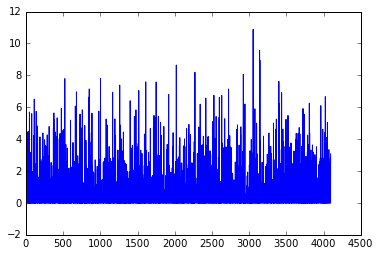

In [28]:
matplotlib.pyplot.plot(np.array(activations[0]))
matplotlib.pyplot.show()

Images with similar content can be expected to have similar activations, that is have a small distance between them. We can run them through a t-SNE to project the 4096-dimension activation vectors down to 2 dimensions, while reasonably preserving these distances between the points.

In [29]:
X = np.array(activations)
tsne = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 22.452870
[t-SNE] Iteration 25: error = 1.0110024, gradient norm = 0.0217269
[t-SNE] Iteration 50: error = 0.9953052, gradient norm = 0.0178012
[t-SNE] Iteration 75: error = 0.7319638, gradient norm = 0.0112362
[t-SNE] Iteration 100: error = 0.7671849, gradient norm = 0.0111895
[t-SNE] Error after 100 iterations with early exaggeration: 0.767185
[t-SNE] Iteration 125: error = 0.6784033, gradient norm = 0.0066416
[t-SNE] Iteration 150: error = 0.7431464, gradient norm = 0.0086054
[t-SNE] Iteration 175: error = 0.8128350, gradient norm = 0.0094431
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.812835


Now let's also normalize the t-SNE so all values are between 0 and 1.

In [30]:
# normalize t-sne points to {0,1}
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results.

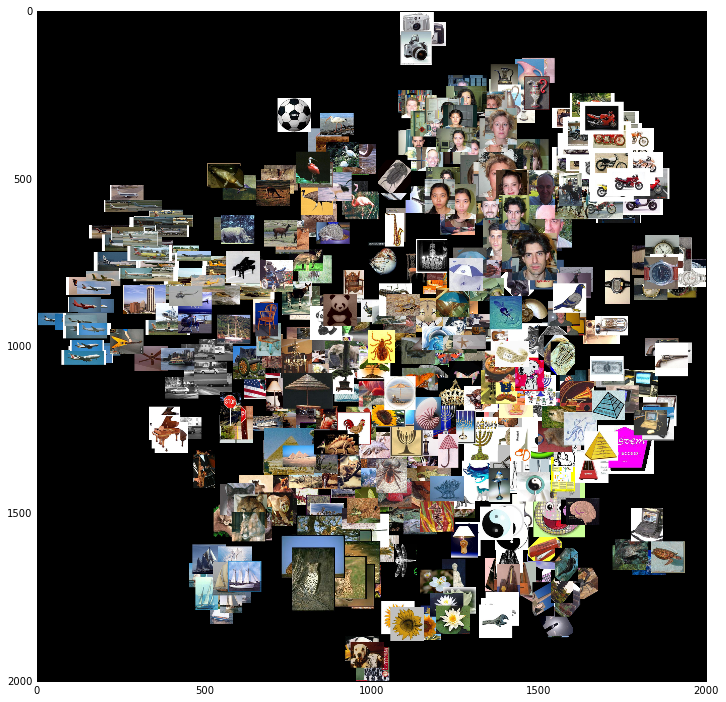

In [36]:
width = 2000
height = 2000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((tile.width/rs, tile.height/rs), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))

matplotlib.pyplot.figure(figsize = (12,12))
imshow(full_image)

You can save the t-SNE image to disk.

In [39]:
full_image.save("myTSNE.png")

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [46]:
tsne_path = "myTSNE.json"

data = [{"path":os.path.abspath(os.path.join(images_path,img)), "point":[x, y]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to myTSNE.json


**TO-DO**
 - point to openframeworks real-time demo
 - convert t-SNE to grid